## 1. Importing Libraries


In [28]:
import string
import pandas as pd 
import tensorflow as tf

from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
import keras


## 2. Loading and Exploring the Data

In [29]:
test = pd.read_csv('data/cyberbullying_test.csv')
train = pd.read_csv('data/cyberbullying_train.csv')
val = pd.read_csv('data/cyberbullying_val.csv')

In [30]:
test['target'] = 'test'
train['target'] = 'train'
val['target'] = 'val'

In [31]:
df = pd.concat([test,train,val],axis=0).reset_index(drop=True)

## 3. Data Cleaning and Preparation

In [32]:
punc= string.punctuation

df['tweet_text'] = df['tweet_text'].str.lower().str.strip().replace(f'[{punc}]','',regex=True)

In [33]:
df = df[df['tweet_text'] != '']

In [34]:
lblencoder = LabelEncoder()
df['cyberbullying_type'] = lblencoder.fit_transform(df['cyberbullying_type'])

## 4. Scaling or Normalizing Data


In [35]:
train = df[df['target'] == 'train'].drop(columns='target').reset_index(drop=True)
test = df[df['target'] == 'test'].drop(columns='target').reset_index(drop=True)
val = df[df['target'] == 'val'].drop(columns='target').reset_index(drop=True)

In [36]:
x_train = train['tweet_text'].values
y_train = train['cyberbullying_type'].values

x_test = test['tweet_text'].values
y_test = test['cyberbullying_type'].values

x_val = val['tweet_text'].values
y_val = val['cyberbullying_type'].values

In [74]:
# Crear datasets de TensorFlow
raw_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
raw_val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [75]:
vocab_size = 25000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf'
)

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)

start = time.time()
vectorize_layer.adapt(text_ds)
print(f'Time for adapt is {time.time()-start:.4f}')

Time for adapt is 348.5307


In [76]:
batch_size = 64
raw_train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
raw_val_ds = raw_val_ds.shuffle(20000).batch(batch_size)
raw_test_ds = raw_test_ds.shuffle(20000).batch(batch_size)

In [77]:
for inp, target in raw_train_ds.take(1):
    print(inp[:2], target[:2])
    
vectorize_layer(inp)

tf.Tensor(
[b'when its a 12year gay kid on the other end of the conversation and he goes and kills himself over it or a college kid decides that those rape jokes mean its okay for him to screw some girl whos saying no yeahits a real problem'
 b'what dumb nigger fighting on the field u get paid 10000000chill the fuck out monkey'], shape=(2,), dtype=string) tf.Tensor([2 1], shape=(2,), dtype=int32)


<tf.Tensor: shape=(64, 25000), dtype=float32, numpy=
array([[8.726831 , 2.467025 , 3.9992914, ..., 0.       , 0.       ,
        0.       ],
       [8.726831 , 2.467025 , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.2335125, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 3.7005377, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [8.726831 , 1.2335125, 1.3330971, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 2.467025 , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

In [78]:
def preprocess(x,y):
    x = vectorize_layer(x)
    y = tf.one_hot(y, depth=6)
    return x,y

train_ds = raw_train_ds.map(lambda x,y: preprocess(x,y))
test_ds = raw_test_ds.map(lambda x,y: preprocess(x,y))
val_ds = raw_val_ds.map(lambda x,y: preprocess(x,y))

In [79]:
next(iter(train_ds))

(<tf.Tensor: shape=(64, 25000), dtype=float32, numpy=
 array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 8.726831 ,  1.2335125,  2.6661942, ...,  0.       ,  0.       ,
          0.       ],
        ...,
        [52.36099  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ],
        [ 0.       ,  0.       ,  1.3330971, ...,  0.       ,  0.       ,
          0.       ],
        [ 8.726831 ,  0.       ,  1.3330971, ...,  0.       ,  0.       ,
          0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(64, 6), dtype=float32, numpy=
 array([[0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 

## 5. Model Building and Training


In [80]:
@keras.saving.register_keras_serializable()
class Linear(keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super().__init__()
        self.num_outputs = num_outputs
        self.activation = keras.activations.get(activation)
        self.batch_norm = keras.layers.BatchNormalization()


    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=[input_dim, self.num_outputs], 
            name="kernel", 
            regularizer=keras.regularizers.l2(0.01)
        )
        self.b = self.add_weight(shape=[self.num_outputs], name="bias")


    def call(self, inputs, training=False):
        x = tf.matmul(inputs, self.w) + self.b
        
        x = self.batch_norm(x, training=training)
        return self.activation(x)

In [81]:
@keras.saving.register_keras_serializable()
class Model(keras.Model):
    def __init__(self, activation, dropout_rate=0.5):
        super().__init__()
        self.l1 = Linear(128, activation) 
        self.batch_norm1 = keras.layers.BatchNormalization()  
        self.dropout1 = keras.layers.Dropout(dropout_rate)  
        self.l2 = Linear(6, activation='softmax') 

    def call(self, x, training=False):
        x = self.l1(x)
        x = self.batch_norm1(x, training=training) 
        x = self.dropout1(x, training=training) 
        return self.l2(x)

### relu - 0.001

In [82]:
model = Model('relu')

In [83]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    callbacks=[early_stopping], 
)

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.7357 - loss: 1.4371 - val_accuracy: 0.8303 - val_loss: 1.1992
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.8435 - loss: 1.0965 - val_accuracy: 0.8232 - val_loss: 1.1563
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - accuracy: 0.8441 - loss: 1.1123 - val_accuracy: 0.8265 - val_loss: 1.1545
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.8429 - loss: 1.1266 - val_accuracy: 0.8330 - val_loss: 1.1882
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 75s 144ms/step - accuracy: 0.8385 - loss: 1.1553 - val_accuracy: 0.8281 - val_loss: 1.1637
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - accuracy: 0.8414 - loss: 1.1480 - val_accuracy: 0.8258 - val_loss: 1.1940
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 75s 144ms/step - accuracy: 0.8408 - loss: 1.1558 - val_accuracy: 0.8285 - val_loss: 1.1753
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 74s 142ms/step - accuracy: 0.8390 - loss: 1

In [84]:
model.save_weights("best_model.weights.h5") 

## 6. Model Evaluation

In [85]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


loaded_model = Model(activation='relu') 
loaded_model.load_weights("best_model.weights.h5")  


loaded_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)


test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f"Loss en test: {test_loss}, Accuracy en test: {test_accuracy}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.1825 - loss: 4.5570
Loss en test: 4.5601677894592285, Accuracy en test: 0.1761498600244522


In [86]:
# Obtener las predicciones
predictions = loaded_model.predict(test_ds)

#  predicciones a clases
predicted_classes = np.argmax(predictions, axis=1)

# etiquetas verdaderas
true_classes = np.concatenate([y for _, y in test_ds], axis=0)  # 
true_classes = np.argmax(true_classes, axis=1)

112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step


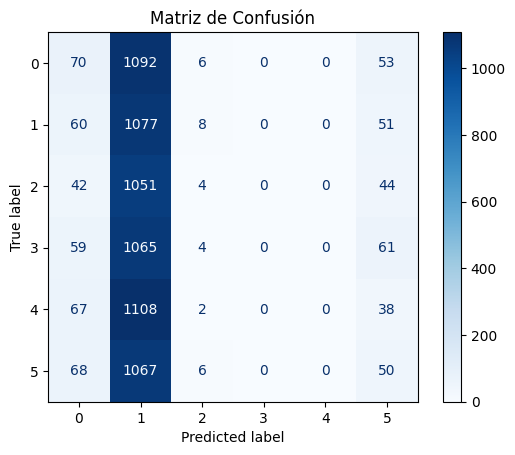

In [87]:
# 
cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(test['cyberbullying_type'],predicted_classes)

0.16650356493778834

In [89]:
test['cyberbullying_type'].value_counts()

cyberbullying_type
0    1221
4    1215
1    1196
5    1191
3    1189
2    1141
Name: count, dtype: int64

In [90]:
pd.DataFrame(predicted_classes).value_counts()

0
1    6460
0     366
5     297
2      30
Name: count, dtype: int64

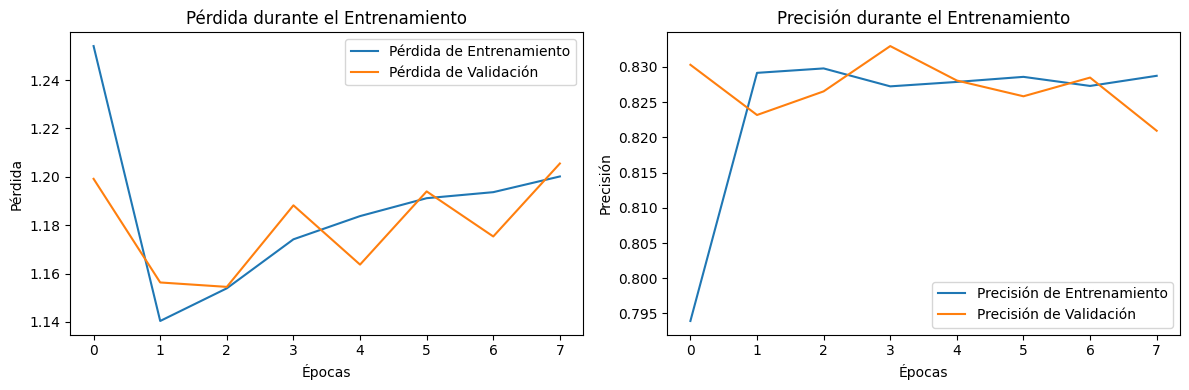

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()
